<a href="https://colab.research.google.com/github/who-knows-its-nebulose/Chair_Style_classifier/blob/main/classification_chair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls "/content/drive/My Drive/Colab Notebooks"

chairs/                     Classificaton_finetune.ipynb  Untitled1.ipynb
classification_chair.ipynb  Untitled0.ipynb


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

img_height = 224
img_width = 224
batch_size = 16


#model = keras.Sequential([
#                          layers.Input((28,28,1)),
#                          layers.Conv2D(16,3, padding='same'),
#                          layers.Conv2D(32,3, padding='same'),
#                          layers.MaxPooling2D(),
#                          layers.Flatten(),
#                          layers.Dense(10),
#])




In [ ]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "categorical",
    class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.2,
    subset = "training",
)

ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "categorical",
    class_names= ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.2,
    subset = "validation",
)


  

Found 1705 files belonging to 5 classes.
Using 1364 files for training.
Found 1705 files belonging to 5 classes.
Using 341 files for validation.


In [ ]:
class_names = ds_train.class_names
print(class_names)

In [ ]:
print(ds_valid)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


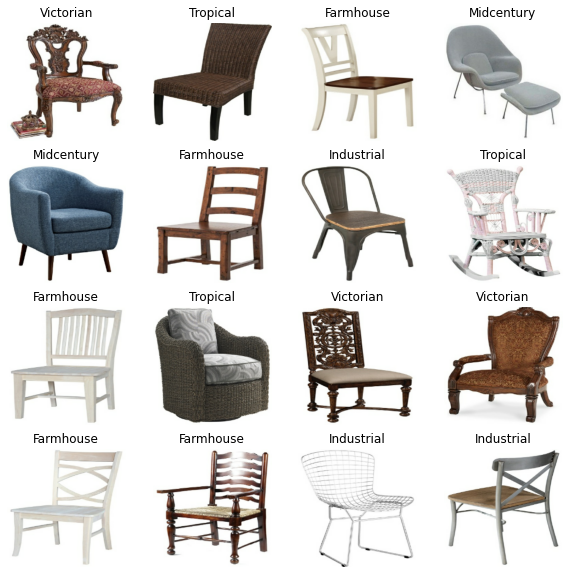

In [31]:
#look at the dataset

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
    int_labels = np.argmax(labels, axis=-1)
    plt.title(class_names[int_labels[i]])
    plt.axis("off")

In [ ]:
for images, labels in ds_train.take(1):
  int_labels = np.argmax(labels, axis=-1)
  print(class_names(int_labels))

In [ ]:
#from tensorflow.keras.layers.experimental import preprocessing
#from tensorflow.keras.models import Sequential
img_augmentation = keras.Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomFlip("horizontal"),
       # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
       # preprocessing.RandomFlip(),
       # preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(image)
        # aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
#        plt.title(int(labels[i]))
#       plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [ ]:
image_size = (img_height, img_width)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = img_augmentation(inputs)
    #x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 1, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)


In [ ]:
ds_train = ds_train.prefetch(buffer_size=32) 
ds_valid = ds_valid.prefetch(buffer_size=32)

In [ ]:
#Adam optimizer

epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    #loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    ds_train, epochs=epochs, callbacks=callbacks, validation_data=ds_valid,
)

In [ ]:

# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
	layer.trainable = False

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

In [ ]:
#Adam optimizer

epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    #loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    ds_train, epochs=epochs, callbacks=callbacks, validation_data=ds_valid,
)

FROM scratch

In [ ]:

model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))


# In[33]:


model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])


# In[34]:

callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
# autosave best Model
best_model_file = "./batch_normalized_weights.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)


# In[ ]:

history = model.fit(train_features, onehot_train, batch_size=10, nb_epoch=10,
              validation_data=(valid_features,onehot_valid),shuffle=True,callbacks = [callbacks,best_model])


# In[ ]:

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()